In [2]:
import pandas as pd
import numpy as np

import torch
from torch import nn 
from torch.utils.data import DataLoader     # 데이터로더는 데이터셋을 iterable하게 감싸는 역할

from torchvision import datasets            # 데이터셋은 샘플과 정답을 저장함
from torchvision.transforms import ToTensor

import clip

from PIL import Image

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

## Our Model

In [4]:
import deeplake
from torchvision import transforms, models

ds_train = deeplake.load('hub://activeloop/pacs-train')
ds_test = deeplake.load('hub://activeloop/pacs-test')

c:\Users\alllh\anaconda3\envs\dev\lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (3.2.12) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


hub://activeloop/pacs-train loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/pacs-train
hub://activeloop/pacs-test loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/pacs-test


In [5]:
batch_size = 8

tform = transforms.Compose([
    transforms.RandomRotation(20), # Image augmentation
    transforms.ToTensor(), # Must convert to pytorch tensor for subsequent operations to run
    # transforms.Normalize([0.5], [0.5]),
])

train_loader = ds_train.pytorch(num_workers = 0, shuffle = True, 
                                transform = {'images': tform, 'labels': None}, 
                                batch_size = batch_size, decode_method = {'images': 'pil'})
test_loader = ds_test.pytorch(num_workers = 0, transform = {'images': tform, 'labels': None}, 
                                batch_size = batch_size, decode_method = {'images': 'pil'})

In [6]:
import matplotlib.pyplot as plt
import torchvision

def imshow(img):
    plt.figure(figsize=(10, 100))
    plt.imshow(img.permute(1,2,0).numpy())
    plt.show()

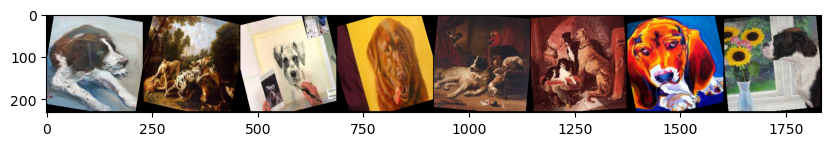

torch.Size([8, 3, 227, 227])


In [7]:
images, labels = next(iter(test_loader))
imshow(torchvision.utils.make_grid(images, nrow=8))
print(images.shape)

In [8]:
# image data -> iamge_features
# class data -> class_features  (fixed!)
# label data 
# image sim class -> label

def get_image_features(clip_model, images):
    num_image_layer = clip_model.visual.transformer.layers
    images = images.to(device)

    out_list = []
    x = clip_model.visual.conv1(images.type(clip_model.dtype))
    x = x.reshape(x.shape[0], x.shape[1], -1)   # shape = [*, width, grid ** 2]
    x = x.permute(0, 2, 1)                      # shape = [*, grid ** 2, width]
    x = torch.cat([clip_model.visual.class_embedding.to(x.dtype) + 
                   torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
    x = x + clip_model.visual.positional_embedding.to(x.dtype)
    x = clip_model.visual.ln_pre(x)
    x = x.permute(1, 0, 2)          # NLD -> LND

    for i in range(num_image_layer):
        x = clip_model.visual.transformer.resblocks[i](x)
        tmp = x.permute(1, 0, 2)    # LND -> NLD
        tmp = tmp[:, 0, :].detach()
        out_list.append(tmp)

    image_features = torch.stack(out_list)

    return image_features

def get_text_features(clip_model, texts):
    num_text_layer = clip_model.transformer.layers
    texts = texts.to(device)

    out_list = []
    x = clip_model.token_embedding(texts).type(clip_model.dtype)  # [batch_size, n_ctx, d_clip_model]
    x = x + clip_model.positional_embedding.type(clip_model.dtype)
    x = x.permute(1, 0, 2)                  # NLD -> LND

    for i in range(num_text_layer):
        x = clip_model.transformer.resblocks[i](x)
        tmp = x.permute(1, 0, 2).detach()   # LND -> NLD
        out_list.append(tmp)

    text_features = torch.stack(out_list)

    return text_features

In [9]:
image_features = get_image_features(clip_model, images)
image_features.shape

torch.Size([12, 8, 768])

In [10]:
pacs_class = [
    'a dog', 'an elephant', 'a giraffe', 'a guitar', 'a horse', 'a house', 'a person'
]

def prompt(idx):
    return f"An image of {pacs_class[idx]}"

prompts = [prompt(x) for x in range(7)]
class_tokens = clip.tokenize([prompt(x) for x in range(7)]).to(device)
print(prompts)

['An image of a dog', 'An image of an elephant', 'An image of a giraffe', 'An image of a guitar', 'An image of a horse', 'An image of a house', 'An image of a person']


In [11]:
class_features = get_text_features(clip_model, class_tokens)
class_features.shape

torch.Size([12, 7, 77, 512])

#### lab

In [12]:
image_features2 = clip_model.visual.ln_post(image_features)                   # (12, batch_size, 768)
image_embeddings = image_features2 @ clip_model.visual.proj      # (12, batch_size, 512)  <- we'll use it

class_features2 = clip_model.ln_final(class_features).type(clip_model.dtype)   # (12, seq_len, 77, 512)
class_embeddings = class_features2[:, torch.arange(class_features2.shape[1]), class_tokens.argmax(dim=-1)] @ clip_model.text_projection
                                                                # (12, seq_len, 512)  <- we'll use it

score_tensor = torch.einsum("ijk,mnk->jnim",image_embeddings, class_embeddings)
score_tensor = score_tensor.reshape(*score_tensor.shape[:2],-1)


In [13]:
### score test
score_tensor = torch.einsum("ijk,mnk->jnim",image_embeddings, class_embeddings)
score_tensor = score_tensor.reshape(*score_tensor.shape[:2],-1)

## score 1
# torch.max(score_tensor, dim=-1)[0]

## score 2
torch.mean(score_tensor, dim=-1)

## score 3
# torch.sum(torch.sigmoid(100 * score_tensor.clone().normal_()), dim=-1)
# torch.softmax(score_tensor, dim=-1).exp().sum(dim=-1)
# torch.sigmoid(100 * score_tensor.clone().normal_()).sum(dim=-1)
# score_tensor.clone().min(), score_tensor.clone().max()
# (score_tensor>20).sum(dim=-1)
# x = torch.sigmoid((score_tensor-20)*1000)
# x.sum(dim=-1), (score_tensor>20).sum(dim=-1)

## score 4 : 이미지의 각 레이어에 대해 가장 높은 연관성을 보이는 텍스트 레이어를 찾고 활용히기
score_tensor = torch.einsum("ijk,mnk->jnim",image_embeddings, class_embeddings)
score_tensor.max(dim=-1)[0].mean(dim=-1)

tensor([[30.1406, 24.3594, 23.1719, 22.6406, 29.7031, 27.6719, 33.5000],
        [29.3125, 24.1562, 23.3438, 22.4062, 29.7500, 27.9531, 32.3750],
        [29.9688, 24.1406, 23.1562, 22.4531, 29.4062, 27.7812, 33.2188],
        [30.2188, 24.3125, 23.5625, 23.0156, 29.8125, 27.8438, 33.8438],
        [29.3281, 23.6250, 22.5625, 22.2344, 29.2656, 27.7812, 32.6562],
        [29.2188, 23.3906, 22.2969, 22.0156, 28.7969, 27.5781, 32.3125],
        [29.5781, 23.4531, 22.7812, 22.1406, 28.9531, 26.6719, 32.9062],
        [29.5156, 23.4219, 22.6719, 21.7188, 28.9844, 27.5938, 32.7812]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward1>)

In [14]:
# torch.tanh(torch.randn_like(clip_model.visual.proj, dtype=torch.float16)).max()
# clip_model.visual.proj.min(), clip_model.visual.proj.max()
# (torch.randn_like(clip_model.visual.proj, dtype=torch.float16, requires_grad=True)/50)
# torch.rand_like(clip_model.text_projection, dtype=torch.float16).min(), torch.rand_like(clip_model.text_projection, dtype=torch.float16).max()
# clip_model.text_projection.min(), clip_model.text_projection.max()
(torch.rand_like(clip_model.visual.proj, dtype=torch.float16)/5-0.1).max()

tensor(0.1000, device='cuda:0', dtype=torch.float16)

#### Model

In [89]:
torch.sigmoid(100 * (score_tensor-20)).sum(dim=-1)
image_features_list[0].shape

torch.Size([12, 32, 768])

In [93]:
# Define model
class OurCLIP(nn.Module):        
    def __init__(self, clip_model, # use pre-trained clip model
                 use_one_ln1=True, use_one_ln2=True, 
                 use_one_projection1=True, use_one_projection2=True,
                 projection_random_init1=False, 
                 projection_random_init2=False, 
                 trainable_ln1=False, trainable_ln2=False, 
                 trainable_projection1=False, trainable_projection2=False,
                 threshold = 100, score_type=0): 
        super().__init__()

        self.dtype = clip_model.dtype
        self.threshold = threshold
        self.score_type = score_type

        self.threshold_weight = nn.Parameter(torch.rand(1)).requires_grad_(True)

        ####################### 미구현
        if use_one_ln1:
            self.ln_post = clip_model.visual.ln_post.requires_grad_(trainable_ln1)
        else: pass
        if use_one_ln2:
            self.ln_final = clip_model.ln_final.requires_grad_(trainable_ln2)
        else: pass
        ########################

        if use_one_projection1:
            self.visual_projection = nn.Parameter(clip_model.visual.proj.clone().detach()).requires_grad_(trainable_projection1)
        else:
            if projection_random_init1:
                self.visual_projection = nn.Parameter(
                    torch.stack([
                        torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.visual.proj, dtype=torch.float16)/50,
                        clip_model.visual.proj.clone().detach()
                    ])).requires_grad_(trainable_projection1)
            else:
                self.visual_projection = nn.Parameter(
                    torch.stack([
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach(),
                        clip_model.visual.proj.clone().detach()
                    ])).requires_grad_(trainable_projection1)
        
        if use_one_projection2:
            self.textual_projection = nn.Parameter(clip_model.text_projection.clone().detach()).requires_grad_(trainable_projection2)
        else:
            if projection_random_init2:
                self.textual_projection = nn.Parameter(
                    torch.stack([
                        torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                        torch.randn_like(clip_model.text_projection, dtype=torch.float16)/50,
                        clip_model.text_projection.clone().detach()
                    ])).requires_grad_(trainable_projection2)
            else:
                self.textual_projection = nn.Parameter(
                    torch.stack([
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach(),
                        clip_model.text_projection.clone().detach()
                    ])).requires_grad_(trainable_projection2)


    def forward(self, image_features, class_features, class_tokens):    
        image_features2 = self.ln_post(image_features)                      # (12, batch_size, 768)
        image_embeddings = image_features2 @ self.visual_projection         # (12, batch_size, 512)  <- we'll use it

        class_features2 = self.ln_final(class_features).type(self.dtype)    # (12, seq_len, 77, 512)
        class_embeddings = class_features2[:, torch.arange(class_features2.shape[1]), 
                                           class_tokens.argmax(dim=-1)] @ self.textual_projection
                                                                            # (12, seq_len, 512)  <- we'll use it

        score_tensor = torch.einsum("ijk,mnk->jnim",image_embeddings, class_embeddings)
        if self.score_type != 3:
            score_tensor = score_tensor.reshape(*score_tensor.shape[:2],-1)

        if self.score_type == 1:
            return torch.mean(score_tensor, dim=-1)
        if self.score_type == 2:
            return torch.sigmoid(100 * (score_tensor-(self.threshold*self.threshold_weight))).sum(dim=-1)
        if self.score_type == 3:
            return score_tensor.max(dim=-1)[0].mean(dim=-1)
        return torch.max(score_tensor, dim=-1)[0]

In [78]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

model = OurCLIP(clip_model, trainable_projection1=True, trainable_projection2=True).to(device)  # model을 initialize하는 부분
print(model)

OurCLIP(
  (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (ln_final): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)


In [79]:
for name, param in model.named_parameters():
    print(name, param.shape)

threshold_weight torch.Size([1])
visual_projection torch.Size([768, 512])
textual_projection torch.Size([512, 512])
ln_post.weight torch.Size([768])
ln_post.bias torch.Size([768])
ln_final.weight torch.Size([512])
ln_final.bias torch.Size([512])


## Train

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1) # momentum

In [30]:
def get_image_features_and_labels(data_loader):
    image_features_list = []
    labels_list = []

    for i, data in enumerate(data_loader):
        images = data['images']
        labels = torch.squeeze(data['labels'])

        images = images.to(device)
        labels = labels.to(device)

        image_features = get_image_features(clip_model, images)
        
        labels_list.append(labels)
        image_features_list.append(image_features)
    
    return image_features_list, labels_list

In [92]:
import time
import torch.nn.functional as f

def train_one_epoch(model, image_features_list, labels_list, max_iter_num=3000):

    model.train()

    # Zero the performance stats for each epoch
    running_loss = 0.0
    start_time = time.time()
    total = 0
    correct = 0
    
    for i in range(len(image_features_list)):
        image_features = image_features_list[i]
        labels = labels_list[i]
        
        optimizer.zero_grad()
        
        output = model(image_features, class_features, class_tokens)

        # normalize
        # output = f.normalize(output)

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        predicted = torch.argmax(output, dim=-1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
    
        # Print performance statistics
        running_loss += loss.item()
        if i != 0 and i % 10 == 0:    # print every 10 batches
            batch_time = time.time()
            speed = (i+1)/(batch_time-start_time)
            print('[%5d] loss: %.3f, speed: %.2f, accuracy: %.2f %%' %
                  (i, running_loss, speed, accuracy))

            running_loss = 0.0
            total = 0
            correct = 0
        if i != 0 and i % max_iter_num == 0:
            break;

    
def test_model(model, image_features_list, labels_list, max_iter_num=1000):

    model.eval()

    start_time = time.time()
    total = 0
    correct = 0
    with torch.no_grad():
        for i in range(len(image_features_list)):
            image_features = image_features_list[i]
            labels = labels_list[i]

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            output = model(image_features, class_features, class_tokens)

            predicted = torch.argmax(output, dim=-1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
            if i != 0 and i % max_iter_num == 0:
                break
        accuracy = 100 * correct / total
            
        print('Finished Testing')
        print('Testing accuracy: %.1f %%' %(accuracy))
    return accuracy

### inference

In [27]:
batch_size = 32

train_loader = ds_train.pytorch(num_workers = 0, shuffle = True, 
                                transform = {'images': tform, 'labels': None}, 
                                batch_size = batch_size, decode_method = {'images': 'pil'})
test_loader = ds_test.pytorch(num_workers = 0, transform = {'images': tform, 'labels': None}, 
                                batch_size = batch_size, decode_method = {'images': 'pil'})

In [ ]:
train_image_features_list, train_labels_list = get_image_features_and_labels(train_loader)
test_image_features_list, test_labels_list = get_image_features_and_labels(test_loader)

In [33]:
# train all by one tensor / max_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                trainable_projection1=True, trainable_projection2=True,
                score_type=0).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 200

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(model, train_image_features_list, train_labels_list, max_iter_num=1000)
    accuracy = test_model(model, test_image_features_list, test_labels_list)
    with open("output0309.txt", 'a') as f:
        f.write(f"{epoch}\t"+"="*10+"train all by one tensor / max_score\n")
        f.write(f"accuracy: {accuracy:.4f}\n")


print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 1.333, speed: 202.63, accuracy: 94.89 %
[   20] loss: 1.352, speed: 205.17, accuracy: 95.31 %
[   30] loss: 0.404, speed: 214.82, accuracy: 99.06 %
[   40] loss: 0.099, speed: 227.94, accuracy: 100.00 %
[   50] loss: 0.232, speed: 236.14, accuracy: 99.38 %
[   60] loss: 1.165, speed: 239.34, accuracy: 96.56 %
[   70] loss: 0.576, speed: 242.10, accuracy: 99.06 %
[   80] loss: 0.824, speed: 244.53, accuracy: 97.50 %
[   90] loss: 1.499, speed: 244.91, accuracy: 95.62 %
[  100] loss: 2.633, speed: 248.58, accuracy: 92.19 %
[  110] loss: 2.674, speed: 252.29, accuracy: 90.94 %
[  120] loss: 3.231, speed: 254.92, accuracy: 88.75 %
[  130] loss: 2.390, speed: 256.50, accuracy: 90.94 %
[  140] loss: 2.987, speed: 258.91, accuracy: 88.44 %
[  150] loss: 2.508, speed: 259.87, accuracy: 93.12 %
[  160] loss: 1.995, speed: 259.37, accuracy: 92.50 %
[  170] loss: 1.769, speed: 261.06, accuracy: 93.44 %
[  180] loss: 1.399, speed

In [36]:
# train all by one tensor / mean_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                trainable_projection1=True, trainable_projection2=True,
                score_type=1).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 200

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(model, train_image_features_list, train_labels_list, max_iter_num=1000)
    accuracy = test_model(model, test_image_features_list, test_labels_list)
    with open("output0309.txt", 'a') as f:
        f.write(f"{epoch}\t"+"="*10+"train all by one tensor / mean_score\n")
        f.write(f"accuracy: {accuracy:.4f}\n")


print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 14.521, speed: 256.89, accuracy: 60.51 %
[   20] loss: 13.419, speed: 259.77, accuracy: 70.31 %
[   30] loss: 9.488, speed: 260.10, accuracy: 74.06 %
[   40] loss: 5.968, speed: 258.99, accuracy: 83.12 %
[   50] loss: 5.149, speed: 257.78, accuracy: 95.94 %
[   60] loss: 10.961, speed: 266.29, accuracy: 73.12 %
[   70] loss: 12.129, speed: 268.14, accuracy: 64.06 %
[   80] loss: 11.393, speed: 274.58, accuracy: 60.62 %
[   90] loss: 13.797, speed: 278.29, accuracy: 51.88 %
[  100] loss: 14.584, speed: 283.25, accuracy: 44.06 %
[  110] loss: 14.088, speed: 285.79, accuracy: 45.00 %
[  120] loss: 13.934, speed: 288.23, accuracy: 60.31 %
[  130] loss: 13.650, speed: 289.26, accuracy: 50.31 %
[  140] loss: 14.165, speed: 289.25, accuracy: 47.19 %
[  150] loss: 13.970, speed: 291.94, accuracy: 57.81 %
[  160] loss: 13.507, speed: 291.33, accuracy: 62.81 %
[  170] loss: 13.312, speed: 292.08, accuracy: 55.00 %
[  180] loss:

In [97]:
# # train all by one tensor / count_score 
# # reference: https://discuss.pytorch.org/t/is-there-any-soft-way-of-counting-positive-values-with-grad-reserved/158975/2
# clip_model, preprocess = clip.load("ViT-B/32", device=device)
# model = OurCLIP(clip_model, 
#                 trainable_projection1=True, trainable_projection2=True,
#                 score_type=2).to(device)  # model을 initialize하는 부분

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)

# num_epochs = 200

# for epoch in range(num_epochs):  # loop over the dataset multiple times
#     print("------------------ Training Epoch {} ------------------".format(epoch+1))
#     train_one_epoch(model, train_image_features_list, train_labels_list, max_iter_num=1000)
#     accuracy = test_model(model, test_image_features_list, test_labels_list)
#     with open("output0309.txt", 'a') as f:
#         f.write(f"{epoch}\t"+"="*10+"train all by one tensor / count_score\n")
#         f.write(f"accuracy: {accuracy:.4f}\n")

# print('Finished Training')

In [98]:
# train all by one tensor / new_score
# reference: https://discuss.pytorch.org/t/is-there-any-soft-way-of-counting-positive-values-with-grad-reserved/158975/2
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                trainable_projection1=True, trainable_projection2=True,
                score_type=3).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 200

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(model, train_image_features_list, train_labels_list, max_iter_num=1000)
    accuracy = test_model(model, test_image_features_list, test_labels_list)
    with open("output0309.txt", 'a') as f:
        f.write(f"{epoch}\t"+"="*10+"train all by one tensor / new_score\n")
        f.write(f"accuracy: {accuracy:.4f}\n")

print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 58.640, speed: 255.37, accuracy: 30.40 %
[   20] loss: 32.645, speed: 240.93, accuracy: 39.06 %
[   30] loss: 9.271, speed: 237.20, accuracy: 73.44 %
[   40] loss: 3.240, speed: 242.92, accuracy: 98.44 %
[   50] loss: 2.340, speed: 249.58, accuracy: 99.06 %
[   60] loss: 8.096, speed: 257.20, accuracy: 76.88 %
[   70] loss: 9.412, speed: 263.11, accuracy: 84.06 %
[   80] loss: 6.733, speed: 268.27, accuracy: 86.56 %
[   90] loss: 9.125, speed: 273.14, accuracy: 78.75 %
[  100] loss: 10.111, speed: 276.21, accuracy: 79.06 %
[  110] loss: 9.561, speed: 279.26, accuracy: 79.38 %
[  120] loss: 9.080, speed: 281.65, accuracy: 83.44 %
[  130] loss: 8.670, speed: 283.71, accuracy: 86.25 %
[  140] loss: 8.678, speed: 285.97, accuracy: 80.31 %
[  150] loss: 8.674, speed: 287.54, accuracy: 84.06 %
[  160] loss: 7.976, speed: 288.49, accuracy: 83.75 %
[  170] loss: 7.735, speed: 289.81, accuracy: 87.19 %
[  180] loss: 6.655, spe

In [99]:
# train all by each tensor(init with last weight) / max_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                score_type=0).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 200

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(model, train_image_features_list, train_labels_list, max_iter_num=1000)
    accuracy = test_model(model, test_image_features_list, test_labels_list)
    with open("output0309.txt", 'a') as f:
        f.write(f"{epoch}\t"+"="*10+"train all by each tensor(init with last weight) / max_score\n")
        f.write(f"accuracy: {accuracy:.4f}\n")
print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 1.390, speed: 76.35, accuracy: 94.89 %
[   20] loss: 1.215, speed: 83.88, accuracy: 95.31 %
[   30] loss: 0.451, speed: 98.67, accuracy: 99.06 %
[   40] loss: 0.111, speed: 112.26, accuracy: 100.00 %
[   50] loss: 0.245, speed: 122.37, accuracy: 99.38 %
[   60] loss: 1.149, speed: 129.89, accuracy: 96.56 %
[   70] loss: 0.585, speed: 137.31, accuracy: 99.06 %
[   80] loss: 0.815, speed: 143.34, accuracy: 97.50 %
[   90] loss: 1.515, speed: 148.10, accuracy: 95.62 %
[  100] loss: 2.915, speed: 152.13, accuracy: 91.88 %
[  110] loss: 2.737, speed: 155.86, accuracy: 90.00 %
[  120] loss: 3.389, speed: 158.78, accuracy: 88.44 %
[  130] loss: 2.516, speed: 161.56, accuracy: 90.94 %
[  140] loss: 3.172, speed: 164.15, accuracy: 88.12 %
[  150] loss: 2.533, speed: 166.32, accuracy: 93.12 %
[  160] loss: 2.057, speed: 168.13, accuracy: 92.19 %
[  170] loss: 1.774, speed: 170.06, accuracy: 92.81 %
[  180] loss: 1.413, speed: 1

In [100]:
# train all by each tensor(init with last weight) / mean_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                score_type=1).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 200

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(model, train_image_features_list, train_labels_list, max_iter_num=1000)
    accuracy = test_model(model, test_image_features_list, test_labels_list)
    with open("output0309.txt", 'a') as f:
        f.write(f"{epoch}\t"+"="*10+"train all by each tensor(init with last weight) / mean_score\n")
        f.write(f"accuracy: {accuracy:.4f}\n")
print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 20.625, speed: 60.26, accuracy: 40.62 %
[   20] loss: 13.272, speed: 85.83, accuracy: 72.19 %
[   30] loss: 14.016, speed: 101.86, accuracy: 67.19 %
[   40] loss: 8.661, speed: 113.58, accuracy: 89.38 %
[   50] loss: 7.818, speed: 124.25, accuracy: 88.75 %
[   60] loss: 12.676, speed: 133.15, accuracy: 60.94 %
[   70] loss: 16.532, speed: 139.67, accuracy: 28.12 %
[   80] loss: 13.569, speed: 145.64, accuracy: 65.31 %
[   90] loss: 15.343, speed: 150.48, accuracy: 61.56 %
[  100] loss: 16.999, speed: 154.67, accuracy: 35.31 %
[  110] loss: 15.266, speed: 157.99, accuracy: 42.81 %
[  120] loss: 15.038, speed: 160.66, accuracy: 55.94 %
[  130] loss: 14.278, speed: 163.48, accuracy: 58.44 %
[  140] loss: 14.643, speed: 165.81, accuracy: 53.44 %
[  150] loss: 14.719, speed: 167.78, accuracy: 60.00 %
[  160] loss: 14.430, speed: 169.75, accuracy: 63.44 %
[  170] loss: 14.267, speed: 171.52, accuracy: 75.62 %
[  180] loss: 

In [101]:
# train all by each tensor(init with last weight) / count_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                score_type=2).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 20

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(model, train_image_features_list, train_labels_list, max_iter_num=1000)
    accuracy = test_model(model, test_image_features_list, test_labels_list)
    with open("output0309.txt", 'a') as f:
        f.write(f"{epoch}\t"+"="*10+"train all by each tensor(init with last weight) / count_score\n")
        f.write(f"accuracy: {accuracy:.4f}\n")

print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 20.722, speed: 61.31, accuracy: 14.49 %
[   20] loss: 43.744, speed: 89.45, accuracy: 16.56 %
[   30] loss: 19.459, speed: 106.37, accuracy: 59.69 %
[   40] loss: 19.459, speed: 118.77, accuracy: 58.44 %
[   50] loss: 19.459, speed: 128.49, accuracy: 54.69 %
[   60] loss: 19.459, speed: 136.76, accuracy: 40.00 %
[   70] loss: 19.459, speed: 143.62, accuracy: 0.00 %
[   80] loss: 19.459, speed: 149.19, accuracy: 0.00 %
[   90] loss: 19.459, speed: 154.00, accuracy: 0.62 %
[  100] loss: 19.459, speed: 157.79, accuracy: 0.62 %
[  110] loss: 19.459, speed: 161.18, accuracy: 0.31 %
[  120] loss: 19.459, speed: 164.27, accuracy: 0.62 %
[  130] loss: 19.459, speed: 166.97, accuracy: 1.56 %
[  140] loss: 19.459, speed: 169.15, accuracy: 0.62 %
[  150] loss: 19.459, speed: 170.98, accuracy: 2.19 %
[  160] loss: 19.459, speed: 172.74, accuracy: 0.31 %
[  170] loss: 19.459, speed: 174.15, accuracy: 0.00 %
[  180] loss: 19.459, s

In [102]:
# train all by each tensor(init with last weight) / new_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                score_type=3).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 200

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(model, train_image_features_list, train_labels_list, max_iter_num=1000)
    accuracy = test_model(model, test_image_features_list, test_labels_list)
    with open("output0309.txt", 'a') as f:
        f.write(f"{epoch}\t"+"="*10+"train all by each tensor(init with last weight) / new_score\n")
        f.write(f"accuracy: {accuracy:.4f}\n")

print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 37.880, speed: 73.53, accuracy: 38.92 %
[   20] loss: 45.812, speed: 88.89, accuracy: 30.94 %
[   30] loss: 12.310, speed: 105.48, accuracy: 68.12 %
[   40] loss: 5.606, speed: 116.99, accuracy: 89.69 %
[   50] loss: 4.629, speed: 125.33, accuracy: 98.75 %
[   60] loss: 13.429, speed: 134.28, accuracy: 73.75 %
[   70] loss: 12.802, speed: 141.18, accuracy: 66.56 %
[   80] loss: 11.030, speed: 147.06, accuracy: 58.44 %
[   90] loss: 12.623, speed: 152.16, accuracy: 56.56 %
[  100] loss: 14.482, speed: 156.07, accuracy: 36.56 %
[  110] loss: 13.331, speed: 159.34, accuracy: 47.50 %
[  120] loss: 13.345, speed: 162.41, accuracy: 49.06 %
[  130] loss: 13.856, speed: 164.89, accuracy: 45.94 %
[  140] loss: 13.457, speed: 167.29, accuracy: 45.94 %
[  150] loss: 13.223, speed: 169.61, accuracy: 55.94 %
[  160] loss: 12.656, speed: 171.20, accuracy: 55.31 %
[  170] loss: 12.827, speed: 172.91, accuracy: 47.81 %
[  180] loss: 

In [103]:
# train all by each tensor(init with randn weight) / max_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                projection_random_init1=True,
                projection_random_init2=True,
                score_type=0).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 200

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(model, train_image_features_list, train_labels_list, max_iter_num=1000)
    accuracy = test_model(model, test_image_features_list, test_labels_list)
    with open("output0309.txt", 'a') as f:
        f.write(f"{epoch}\t"+"="*10+"train all by each tensor(init with randn weight) / max_score\n")
        f.write(f"accuracy: {accuracy:.4f}\n")

print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 0.498, speed: 63.12, accuracy: 98.86 %
[   20] loss: 1.028, speed: 91.86, accuracy: 95.94 %
[   30] loss: 0.420, speed: 110.00, accuracy: 99.06 %
[   40] loss: 0.145, speed: 122.17, accuracy: 100.00 %
[   50] loss: 0.255, speed: 132.25, accuracy: 99.38 %
[   60] loss: 1.108, speed: 141.18, accuracy: 96.88 %
[   70] loss: 0.620, speed: 148.30, accuracy: 99.06 %
[   80] loss: 0.782, speed: 154.06, accuracy: 97.50 %
[   90] loss: 1.500, speed: 158.22, accuracy: 95.62 %
[  100] loss: 2.482, speed: 162.59, accuracy: 92.50 %
[  110] loss: 2.701, speed: 166.53, accuracy: 90.31 %
[  120] loss: 3.100, speed: 169.78, accuracy: 89.06 %
[  130] loss: 2.256, speed: 172.78, accuracy: 91.25 %
[  140] loss: 2.809, speed: 175.35, accuracy: 89.69 %
[  150] loss: 2.467, speed: 177.86, accuracy: 92.81 %
[  160] loss: 1.955, speed: 180.08, accuracy: 92.19 %
[  170] loss: 1.769, speed: 181.69, accuracy: 93.12 %
[  180] loss: 1.397, speed: 

In [104]:
model.visual_projection, clip_model.visual.proj

(Parameter containing:
 tensor([[[ 0.0258,  0.0213, -0.0151,  ...,  0.0119,  0.0260, -0.0202],
          [-0.0246, -0.0109,  0.0253,  ..., -0.0057,  0.0352,  0.0186],
          [ 0.0140, -0.0051, -0.0202,  ...,  0.0362,  0.0126, -0.0457],
          ...,
          [ 0.0334,  0.0150, -0.0139,  ...,  0.0339,  0.0044, -0.0120],
          [ 0.0281,  0.0128, -0.0441,  ...,  0.0162,  0.0041, -0.0117],
          [ 0.0088, -0.0049,  0.0036,  ..., -0.0410, -0.0069,  0.0112]],
 
         [[-0.0054, -0.0188, -0.0038,  ...,  0.0100, -0.0236,  0.0084],
          [ 0.0066,  0.0170,  0.0202,  ...,  0.0002,  0.0037, -0.0443],
          [-0.0070, -0.0043,  0.0005,  ..., -0.0419,  0.0134, -0.0417],
          ...,
          [-0.0314,  0.0140,  0.0093,  ..., -0.0151,  0.0171, -0.0165],
          [ 0.0101, -0.0218,  0.0065,  ..., -0.0259, -0.0113,  0.0100],
          [-0.0038,  0.0088,  0.0165,  ..., -0.0399,  0.0090,  0.0362]],
 
         [[ 0.0130, -0.0062,  0.0164,  ..., -0.0054, -0.0089,  0.0255],
     

In [105]:
# train all by each tensor(init with randn weight) / mean_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                projection_random_init1=True,
                projection_random_init2=True,
                score_type=1).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 200

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(model, train_image_features_list, train_labels_list, max_iter_num=1000)
    accuracy = test_model(model, test_image_features_list, test_labels_list)
    with open("output0309.txt", 'a') as f:
        f.write(f"{epoch}\t"+"="*10+"train all by each tensor(init with randn weight) / mean_score\n")
        f.write(f"accuracy: {accuracy:.4f}\n")

print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 20.511, speed: 59.65, accuracy: 29.55 %
[   20] loss: 18.362, speed: 85.24, accuracy: 46.56 %
[   30] loss: 19.285, speed: 102.08, accuracy: 16.88 %
[   40] loss: 17.019, speed: 113.79, accuracy: 59.38 %
[   50] loss: 15.521, speed: 123.42, accuracy: 61.88 %
[   60] loss: 16.620, speed: 132.41, accuracy: 49.06 %
[   70] loss: 20.617, speed: 139.54, accuracy: 0.00 %
[   80] loss: 19.671, speed: 145.26, accuracy: 0.00 %
[   90] loss: 19.797, speed: 150.26, accuracy: 3.44 %
[  100] loss: 20.023, speed: 154.41, accuracy: 1.56 %
[  110] loss: 19.232, speed: 157.88, accuracy: 4.38 %
[  120] loss: 18.825, speed: 161.32, accuracy: 21.88 %
[  130] loss: 18.194, speed: 164.14, accuracy: 27.50 %
[  140] loss: 18.082, speed: 166.52, accuracy: 22.19 %
[  150] loss: 17.866, speed: 168.74, accuracy: 24.06 %
[  160] loss: 17.812, speed: 170.75, accuracy: 20.31 %
[  170] loss: 17.454, speed: 172.59, accuracy: 25.00 %
[  180] loss: 17.

In [106]:
# train all by each tensor(init with randn weight) / count_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                projection_random_init1=True,
                projection_random_init2=True,
                score_type=2).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 20

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(model, train_image_features_list, train_labels_list, max_iter_num=1000)
    accuracy = test_model(model, test_image_features_list, test_labels_list)
    with open("output0309.txt", 'a') as f:
        f.write(f"{epoch}\t"+"="*10+"train all by each tensor(init with randn weight) / count_score\n")
        f.write(f"accuracy: {accuracy:.4f}\n")

print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 21.405, speed: 75.76, accuracy: 0.00 %
[   20] loss: 19.459, speed: 80.45, accuracy: 4.06 %
[   30] loss: 19.459, speed: 96.98, accuracy: 59.69 %
[   40] loss: 19.459, speed: 109.27, accuracy: 58.44 %
[   50] loss: 19.459, speed: 118.34, accuracy: 54.69 %
[   60] loss: 19.459, speed: 125.89, accuracy: 40.00 %
[   70] loss: 19.459, speed: 132.71, accuracy: 0.00 %
[   80] loss: 19.459, speed: 138.06, accuracy: 0.00 %
[   90] loss: 19.459, speed: 142.84, accuracy: 0.62 %
[  100] loss: 19.459, speed: 146.74, accuracy: 0.62 %
[  110] loss: 19.459, speed: 149.96, accuracy: 0.31 %
[  120] loss: 19.459, speed: 152.76, accuracy: 0.62 %
[  130] loss: 19.459, speed: 155.31, accuracy: 1.56 %
[  140] loss: 19.459, speed: 157.49, accuracy: 0.62 %
[  150] loss: 19.459, speed: 159.62, accuracy: 2.19 %
[  160] loss: 19.459, speed: 161.30, accuracy: 0.31 %
[  170] loss: 19.459, speed: 162.92, accuracy: 0.00 %
[  180] loss: 19.459, spee

In [107]:
# train all by each tensor(init with randn weight) / new_score
clip_model, preprocess = clip.load("ViT-B/32", device=device)
model = OurCLIP(clip_model, 
                use_one_projection1=False, use_one_projection2=False,
                trainable_projection1=True, trainable_projection2=True,
                projection_random_init1=True,
                projection_random_init2=True,
                score_type=3).to(device)  # model을 initialize하는 부분

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

num_epochs = 200

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("------------------ Training Epoch {} ------------------".format(epoch+1))
    train_one_epoch(model, train_image_features_list, train_labels_list, max_iter_num=1000)
    accuracy = test_model(model, test_image_features_list, test_labels_list)
    with open("output0309.txt", 'a') as f:
        f.write(f"{epoch}\t"+"="*10+"train all by each tensor(init with randn weight) / new_score\n")
        f.write(f"accuracy: {accuracy:.4f}\n")

print('Finished Training')

------------------ Training Epoch 1 ------------------
[   10] loss: 13.063, speed: 79.06, accuracy: 88.92 %
[   20] loss: 10.420, speed: 105.77, accuracy: 87.81 %
[   30] loss: 10.595, speed: 120.12, accuracy: 80.94 %
[   40] loss: 5.697, speed: 128.77, accuracy: 96.88 %
[   50] loss: 4.558, speed: 137.14, accuracy: 99.06 %
[   60] loss: 8.472, speed: 144.26, accuracy: 75.00 %
[   70] loss: 11.177, speed: 150.22, accuracy: 73.12 %
[   80] loss: 9.474, speed: 154.76, accuracy: 91.88 %
[   90] loss: 11.229, speed: 159.30, accuracy: 78.12 %
[  100] loss: 12.582, speed: 163.49, accuracy: 63.44 %
[  110] loss: 11.260, speed: 166.27, accuracy: 78.12 %
[  120] loss: 10.855, speed: 168.80, accuracy: 84.06 %
[  130] loss: 10.094, speed: 171.20, accuracy: 89.06 %
[  140] loss: 10.138, speed: 173.04, accuracy: 88.12 %
[  150] loss: 10.208, speed: 175.13, accuracy: 84.69 %
[  160] loss: 9.516, speed: 176.51, accuracy: 87.50 %
[  170] loss: 9.381, speed: 177.63, accuracy: 88.44 %
[  180] loss: 9.1

In [ ]:
# zeroshot
def test_model_for_clip_model(clip_model, data_loader, max_iter_num=1000):

    clip_model.eval()

    start_time = time.time()
    total = 0
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data['images']
            labels = torch.squeeze(data['labels'])
        
            inputs = inputs.to(device)
            labels = labels.to(device)

            # inputs = inputs.permute([0, 3, 1, 2])   # N, H, W, C -> N, C, H, W

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = clip_model(inputs, class_tokens)[0].softmax(dim=-1)
    
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if i != 0 and i % max_iter_num == 0:
                break
        accuracy = 100 * correct / total
            
        print('Finished Testing')
        print('Testing accuracy: %.1f %%' %(accuracy))
    return accuracy

In [190]:
clip_model, preprocess = clip.load("ViT-B/32", device=device)
accuracy = test_model_for_clip_model(clip_model, test_loader)
with open("output0309.txt", 'a') as f:
    f.write("="*10+"clip / zeroshot\n")
    f.write(f"accuracy: {accuracy:.4f}\n")

Finished Testing
Testing accuracy: 90.6 %
